<a href="https://colab.research.google.com/github/willdata0101/UT-Austin-ML-AI-Projects/blob/main/Practical_Machine_Learning_Exercise_REPL_WD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For this exercise, I will be using a Google Colab notebook to build an LSTM (Long Short-Term Memory) model. Additionally, I will be demonstrating how to use Facebook's Prophet tool, which makes predictions on time series data, automatically accounting for holidays and off days.



First, I'll start off by importing the necessary libraries and packages.

In [82]:
# Importing libraries

# ML libraries/packages:

import os

import IPython
import IPython.display
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sb
sb.set()

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import matplotlib.dates as mdates
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

def parser(x):
  return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

Next, I'll import the datasets into Pandas DataFrames. Then, as you'll see, I decided to resample the hourly data into monthly data, since the objective is to predict the following month's sales and foot traffic. So, we can assume that the dataset now shows average sales in cents per month and average traffic per hour per month.

In [83]:
# Importing dataset and creating Pandas dataframe

sales = pd.read_csv('training_Sales.csv', header=0, parse_dates=[0], index_col=[0], squeeze=True, date_parser=parser)
traffic = pd.read_csv('training_Traffic.csv', parse_dates=[0], index_col=[0], squeeze=True, date_parser=parser)

# Resampling hourly data into monthly
sales_monthly = sales.resample('M', convention='end').mean()
traffic_monthly = traffic.resample('M', convention='end').mean()

In [84]:
traffic_monthly.head()

Date
2015-01-31    4.420041
2015-02-28    3.513050
2015-03-31    3.527412
2015-04-30    3.369773
2015-05-31    3.894483
Freq: M, Name: Value, dtype: float64

Next, when making predictions with time series data, it's important to check the heteroscedasticity of a dataset, that is, whether the variability of the data changes over time. We can do this by simply plotting the data with Matplotlib:

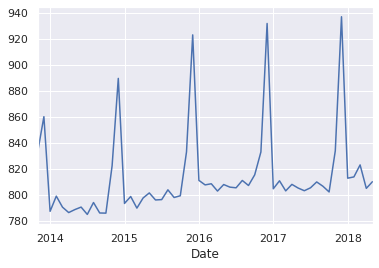

In [162]:
# Plotting monthly sales data
sales_monthly.plot()

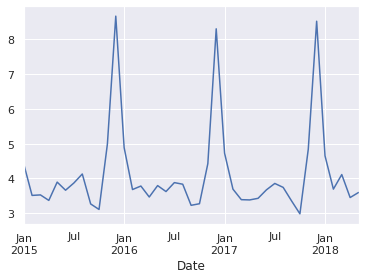

In [163]:
# Plotting monthly traffic data
traffic_monthly.plot()

We can see that both line plots are fairly homoscedastic, since the variability in both cases shows a regular pattern of peaks and valleys. Therefore, we can proceed with the data preprocessing and model building.

In [87]:
# Descriptive statistics for sales
sales_monthly.describe().T

count     55.000000
mean     813.891243
std       33.516087
min      784.824854
25%      797.647815
50%      805.279459
75%      811.830343
max      936.742741
Name: Value, dtype: float64

In [88]:
# Descriptive statistics for traffic
traffic_monthly.describe().T

count    41.000000
mean      4.137976
std       1.331491
min       2.984973
25%       3.452174
50%       3.693233
75%       4.127688
max       8.655482
Name: Value, dtype: float64

Data Preprocessing (imputing missing values)

In [89]:
# Check for missing values
sales_monthly.isnull().values.any(), traffic_monthly.isnull().values.any()

(False, False)

In [90]:
# Check for 0 values
print(sales_monthly[sales_monthly==0])
print()
print(traffic_monthly[traffic_monthly==0])

Series([], Freq: M, Name: Value, dtype: float64)

Series([], Freq: M, Name: Value, dtype: float64)


We can see that the missing values have already been dealt with by virtue of resampling the datasets, which apparently removed the missing values.

Below, I've written a series of functions in order to streamline the data preprocessing and LSTM model building:

* 1. Transforming the dataset into a supervised learning problem
* 2. Scaling and inverse scaling the data
* 3. Fitting the data to the model
* 4. Making predictions with the model

Side note: Since the LSTM expects an input variable (X) and an output variable (y), we are creating a function that uses the last time step as the input and the current time step as the output. This is achieved with a list comprehension and the range function in Python, as seen below.

In [91]:
# Transform time series to supervised learning problem

def timeseries_to_supervised(data, lag=1):
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df

The LSTM requires scaled data in the range -1 to 1, due to the fact that the activation function outputs data in this range.

In [92]:
# Scale train and test data to [-1, 1]
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)
  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)
  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

In order to make a prediction, we have to inverse the scale.

In [93]:
# Inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]

In [108]:
# Fit an LSTM network to training data
def fit_lstm(train, batch_size, epochs, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential([
                      LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True),
                      Dense(1)
  ])
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(epochs):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
  return model

In [95]:
# Make a one-step forecast
def forecast_lstm(model, batch_size, X):
  X = X.reshape(1, 1, len(X))
  y_hat = model.predict(X, batch_size=batch_size)
  return y_hat[0, 0]

In [96]:
# Transform sales data to supervised
raw_sales_monthly = sales_monthly.values
supervised_sales = timeseries_to_supervised(raw_sales_monthly, 1)
supervised_sales_values = supervised_sales.values

In [97]:
# Splitting data into train and test sets

train_sales = supervised_sales_values[0:-12]
test_sales = supervised_sales_values[-12:]

In [149]:
# Transform scale of data
scaler, train_sales_scaled, test_sales_scaled = scale(train_sales, test_sales)

Here, we're fitting the model to the train_sales data, with a batch size of 1, training for 100 epochs, and 100 neurons in the LSTM layer.

In [152]:
# Fit the model
lstm_model = fit_lstm(train_sales_scaled, 1, 100, 100)
# Forecast entire training dataset to build up state for forecasting
train_reshaped = train_sales_scaled[:, 0].reshape(len(train_sales_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

43/43 [==============================] - 0s 2ms/step - loss: 0.1883


array([[-0.43601558],
       [-0.3284087 ],
       [-0.757781  ],
       [-0.48901948],
       [-0.6889219 ],
       [-0.55754507],
       [-0.6498838 ],
       [-0.5853919 ],
       [-0.63295233],
       [-0.600535  ],
       [-0.62410504],
       [-0.61015624],
       [-0.61818856],
       [-0.61965406],
       [-0.64968574],
       [-0.6480408 ],
       [-0.6229945 ],
       [-0.6309735 ],
       [-0.61888444],
       [-0.62815976],
       [-0.62201273],
       [-0.62436056],
       [-0.62353474],
       [-0.62609756],
       [-0.62303513],
       [-0.6321864 ],
       [-0.65925884],
       [-0.666204  ],
       [-0.6309277 ],
       [-0.64297867],
       [-0.62786263],
       [-0.63386244],
       [-0.62896013],
       [-0.6308999 ],
       [-0.62972647],
       [-0.6318939 ],
       [-0.6309924 ],
       [-0.6386369 ],
       [-0.6619249 ],
       [-0.6701217 ],
       [-0.6296852 ],
       [-0.6451279 ],
       [-0.62619084]], dtype=float32)

In [153]:
# Walk-forward validation on the test data
predictions = list()
for i in range(len(test_sales_scaled)):
  # make one-step forecast
  X, y = test_scaled[i, 0:-1], test_sales_scaled[i, -1]
  y_hat = forecast_lstm(lstm_model, 1, X)
  # invert scaling
  y_hat = invert_scale(scaler, X, y_hat)
  # store forecast
  predictions.append(y_hat)
  expected = raw_sales_monthly[len(train_sales) + i]
  print('Month=%d, Predicted=%f, Expected=%f' % (i, y_hat, expected))

Month=0, Predicted=818.788299, Expected=803.035541
Month=1, Predicted=831.540892, Expected=805.280757
Month=2, Predicted=832.216809, Expected=809.780280
Month=3, Predicted=837.569633, Expected=806.486134
Month=4, Predicted=838.537165, Expected=802.099018
Month=5, Predicted=844.910713, Expected=833.783073
Month=6, Predicted=840.429822, Expected=936.742741
Month=7, Predicted=824.225938, Expected=812.667662
Month=8, Predicted=821.120526, Expected=813.649785
Month=9, Predicted=834.655065, Expected=822.874224
Month=10, Predicted=834.430474, Expected=804.843983
Month=11, Predicted=840.291845, Expected=810.000000


In [154]:
# Report performance
rmse = sqrt(mean_squared_error(raw_sales_monthly[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 35.656


We can see that the model for the sales data receives an RMSE (Root Mean Squared Error) of 39.52, which should be in the same units as the original data, in this case cents. So the RMSE is 39.52 cents.

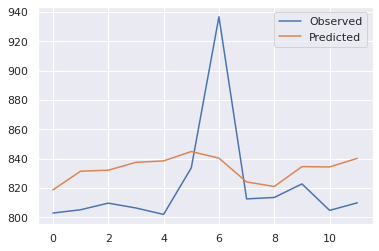

In [155]:
# Line plot of observed vs. predicted
plt.plot(raw_sales_monthly[-12:])
plt.plot(predictions)
plt.legend(['Observed', 'Predicted'])
plt.show()

In [102]:
###

In [103]:
# Transform traffic data to supervised
raw_traffic_monthly = traffic_monthly.values
supervised_traffic = timeseries_to_supervised(raw_traffic_monthly, 1)
supervised_traffic_values = supervised_traffic.values

In [104]:
# Splitting data into train and test sets

train_traffic = supervised_traffic_values[0:-12]
test_traffic = supervised_traffic_values[-12:]

In [156]:
# Transform scale of data
scaler, train_traffic_scaled, test_traffic_scaled = scale(train_traffic, test_traffic)

Here, we're fitting the model to the train_traffic data, with a batch size of 1, training for 100 epochs, and 10 neurons in the LSTM layer.

* Note: Using 100 neurons as in the previous model did not appear to improve model performance.

In [157]:
# Fit the model
lstm_model = fit_lstm(train_traffic_scaled, 1, 100, 10)
# Forecast entire training dataset to build up state for forecasting
train_reshaped = train_traffic_scaled[:, 0].reshape(len(train_traffic_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

29/29 [==============================] - 0s 2ms/step - loss: 0.1896


array([[-0.9326246 ],
       [-0.6381941 ],
       [-0.62733805],
       [-0.5731169 ],
       [-0.5373665 ],
       [-0.47572476],
       [-0.46016464],
       [-0.43123657],
       [-0.40943086],
       [-0.4444452 ],
       [-0.4361789 ],
       [-0.33134866],
       [-0.17240849],
       [-0.44924194],
       [-0.68585944],
       [-0.7630594 ],
       [-0.7971866 ],
       [-0.7733772 ],
       [-0.7660291 ],
       [-0.7337527 ],
       [-0.7189398 ],
       [-0.7207376 ],
       [-0.6756332 ],
       [-0.58568954],
       [-0.40154764],
       [-0.6832956 ],
       [-0.864076  ],
       [-0.9149387 ],
       [-0.90137327]], dtype=float32)

In [158]:
# Walk-forward validation on the test data
predictions = list()
for i in range(len(test_traffic_scaled)):
  # make one-step forecast
  X, y = test_scaled[i, 0:-1], test_traffic_scaled[i, -1]
  y_hat = forecast_lstm(lstm_model, 1, X)
  # invert scaling
  y_hat = invert_scale(scaler, X, y_hat)
  # store forecast
  predictions.append(y_hat)
  expected = raw_traffic_monthly[len(train_traffic) + i]
  print('Month=%d, Predicted=%f, Expected=%f' % (i, y_hat, expected))

Month=0, Predicted=3.481903, Expected=3.672438
Month=1, Predicted=3.616933, Expected=3.856061
Month=2, Predicted=3.728872, Expected=3.743198
Month=3, Predicted=3.790200, Expected=3.356504
Month=4, Predicted=3.833796, Expected=2.984973
Month=5, Predicted=3.926817, Expected=4.839863
Month=6, Predicted=4.285111, Expected=8.509581
Month=7, Predicted=4.749959, Expected=4.647410
Month=8, Predicted=3.906238, Expected=3.693233
Month=9, Predicted=3.401444, Expected=4.110884
Month=10, Predicted=3.324740, Expected=3.452174
Month=11, Predicted=3.207922, Expected=3.596429


In [159]:
# Report performance
rmse = sqrt(mean_squared_error(raw_traffic_monthly[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.304


Here, we can see that the model for the traffic data receives an RMSE of 1.304, which we can simplify to approximately 1 person. So, the model is predicting the hourly traffic with an RMSE of 1 person.

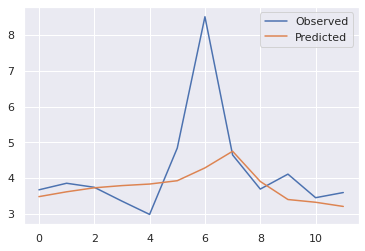

In [160]:
# Line plot of observed vs. predicted
plt.plot(raw_traffic_monthly[-12:])
plt.plot(predictions)
plt.legend(['Observed', 'Predicted'])
plt.show()

Finally, I decided to use Facebook's open-source library, Prophet, to make predictions on the data. The advantage of Prophet is that factors such as trends, seasons, and holidays, are automatically taken into account when forecasting on time series data.

In [166]:
# Importing dataset and creating Pandas dataframe

sales = pd.read_csv('training_Sales.csv', header=0)
traffic = pd.read_csv('training_Traffic.csv', header=0)

# Removing 0 values

sales.replace(0, sales.median(), inplace=True)
traffic.replace(0, traffic.median(), inplace=True)

In [167]:
# Using Prophet to make predictions for next month
from fbprophet import Prophet

# Changing column names to expected
sales.columns = ['ds', 'y']
traffic.columns = ['ds', 'y']

# Converting to datetime
sales['ds'] = pd.to_datetime(sales['ds'])
traffic['ds'] = pd.to_datetime(traffic['ds'])

Below, I've instructed Prophet to start looking at the 2018 dates, toward the end of the dataset, and then project into the future from there. I've applied this methodology to both the sales and traffic datasets.

In [168]:
# Define the model for sales
model_1 = Prophet()

# Fit the model
model_1.fit(sales)

# Define period for which we want a prediction
future = list()
for i in range(1, 13):
  date = '2018-%02d' % i
  future.append([date])
  
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

          ds        yhat  yhat_lower  yhat_upper
0 2018-01-01  826.859480  714.211577  937.199016
1 2018-02-01  763.777171  658.145837  882.101244
2 2018-03-01  748.900621  635.856928  858.357099
3 2018-04-01  792.599605  686.083678  901.592511
4 2018-05-01  735.514124  626.261655  840.170263
5 2018-06-01  740.397365  642.563054  858.222408
6 2018-07-01  781.813487  668.133359  885.535260
7 2018-08-01  743.028930  628.637819  852.555674
8 2018-09-01  783.704774  668.119853  898.654692
9 2018-10-01  760.523774  641.458101  881.932778


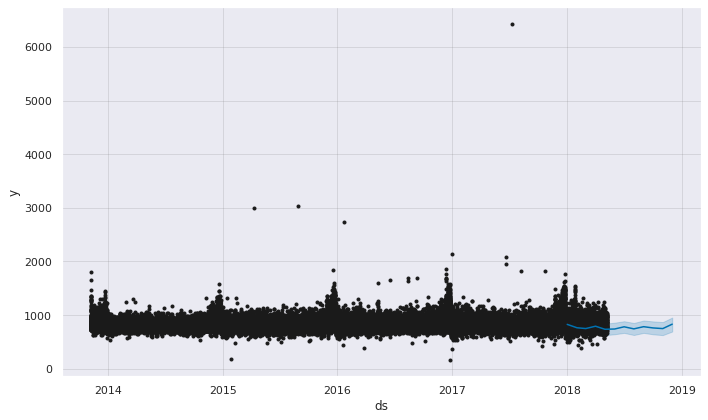

In [169]:
# Use model to make a sales forecast
forecast = model_1.predict(future)

# Summarize forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))

# Plot forecast
model_1.plot(forecast)
plt.show()

In [171]:
# Checking the last month in the sales dataset
sales_monthly.tail()

Date
2018-01-31    812.667662
2018-02-28    813.649785
2018-03-31    822.874224
2018-04-30    804.843983
2018-05-31    810.000000
Freq: M, Name: Value, dtype: float64

According to the above table and graph, since the last month in the sales dataset is represented by May 31, the first clear prediction is July 2018, with a y-hat value of 781.81 cents. There are also lower- and upper-bound predictions, coming in at 668.13 and 885.53, respectively.

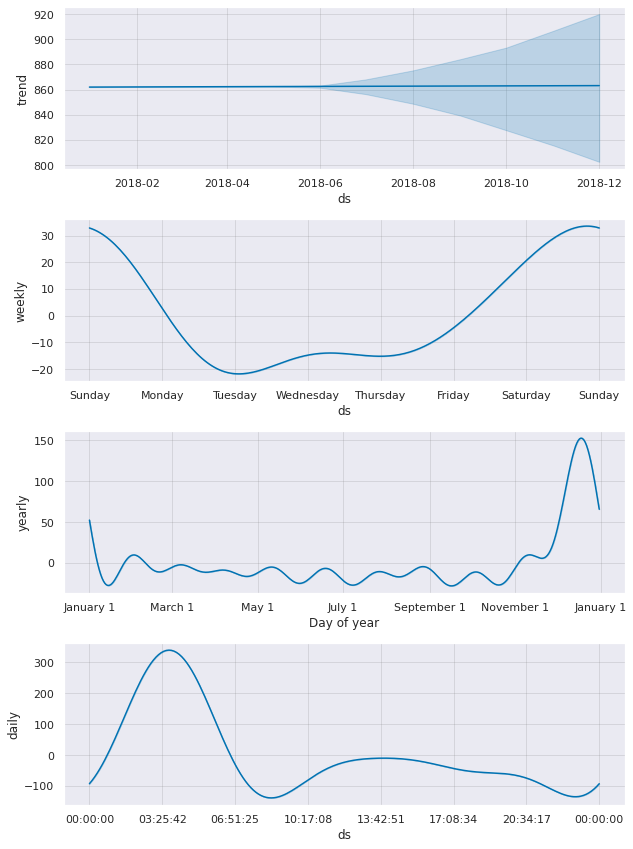

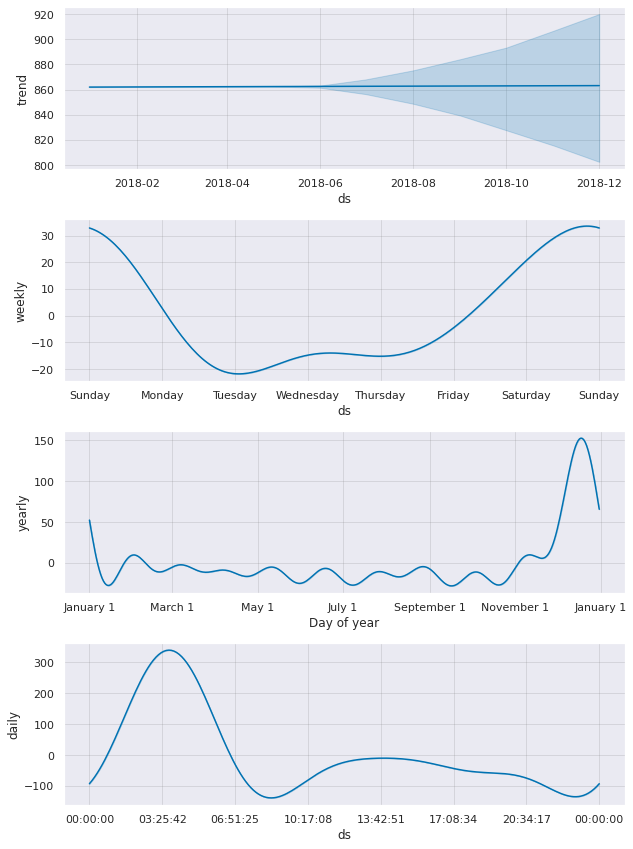

In [172]:
model_1.plot_components(forecast)

In [173]:
# Define the model for traffic
model_2 = Prophet()

# Fit the model
model_2.fit(traffic)

# Define period for which we want a prediction
future = list()
for i in range(1, 13):
  date = '2018-%02d' % i
  future.append([date])
  
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

          ds      yhat  yhat_lower  yhat_upper
0 2018-01-01  7.306598    3.923741   10.762376
1 2018-02-01 -0.427349   -3.740105    3.447363
2 2018-03-01 -0.794298   -4.286807    2.846204
3 2018-04-01  3.765226    0.395977    7.136108
4 2018-05-01 -0.901146   -4.519577    2.378780
5 2018-06-01 -0.148371   -3.788669    3.408861
6 2018-07-01  3.781311    0.150102    6.981847
7 2018-08-01  0.412737   -3.091632    3.946425
8 2018-09-01  2.158661   -1.645751    5.778241
9 2018-10-01  1.099519   -2.422167    4.554123


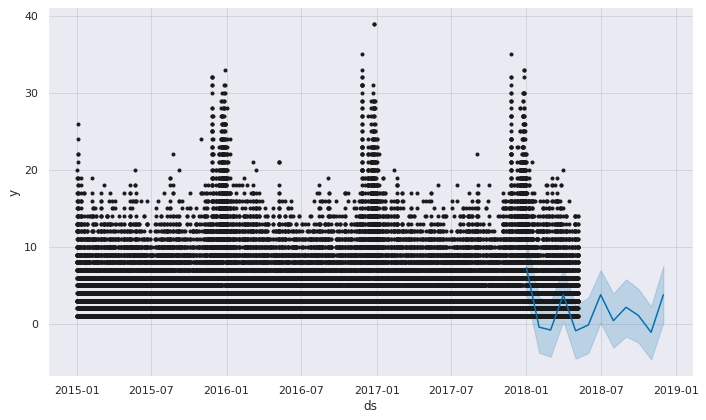

In [174]:
# Use model to make a traffic forecast
forecast = model_2.predict(future)

# Summarize forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))

# Plot forecast
model_2.plot(forecast)
plt.show()

This model produces strange results. I'm not sure why it's returning negative y-hat values in so many cases, but a possible fix could be to take the natural log of the values for the traffic per hour.

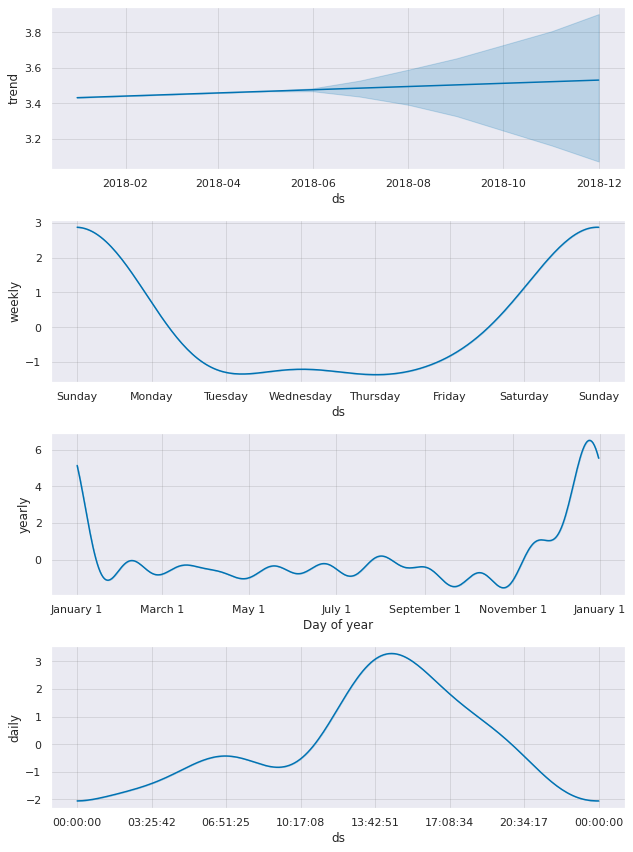

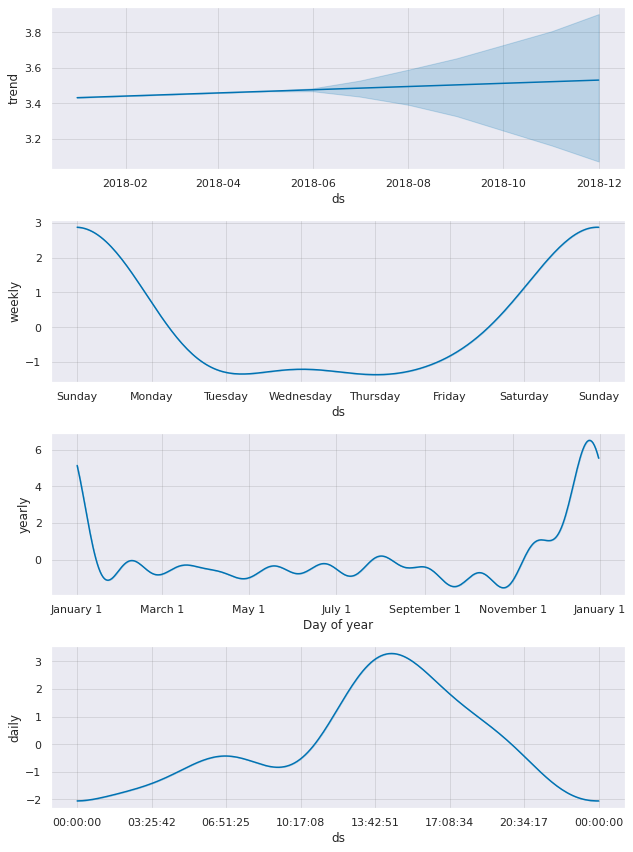

In [80]:
model_2.plot_components(forecast)